<a href="https://colab.research.google.com/github/wheemin-2/24-2-ESAA/blob/main/1115_HW_Kaggle3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **House Prices - Advanced Regression Techniques**

https://www.kaggle.com/code/subinium/subinium-tutorial-house-prices-advanced

# **데이터 전처리**

In [1]:
# 모듈 임포트
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# sns Theme
sns.set_style('darkgrid')

# 소수점 표현 제한
pd.set_option('display.float_format', lambda x : '{:.3f}'.format(x))

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# data load
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/house price/house_price.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ESAA/data/house price/test.csv')

In [4]:
# check
print(train_df.shape, test_df.shape)
train_df.head(5)

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## **불필요한 칼럼 제거**

In [5]:
# 'Id' 칼럼 저장
train_ID = train_df['Id']
test_ID = test_df['Id']

# drop 'Id'
train_df.drop('Id',axis=1,inplace=True)
test_df.drop('Id',axis=1,inplace=True)

## **outlier 제거**

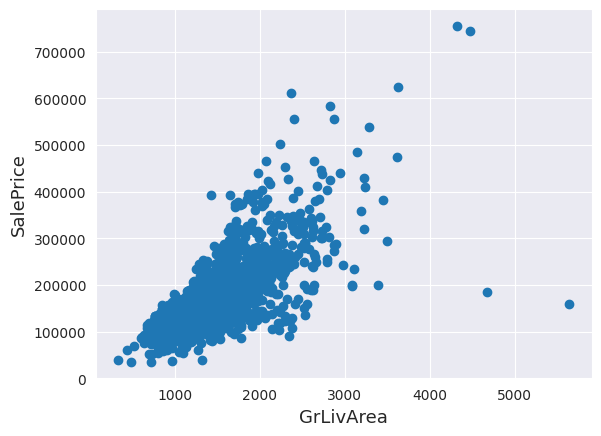

In [6]:
fig, ax = plt.subplots()

ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice',fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [7]:
# outlier 제거
cond1 = train_df['GrLivArea'] > 4000
cond2 = train_df['SalePrice'] < 200000

outlier_index = train_df[cond1 & cond2].index
train_df = train_df.drop(outlier_index)
train_df.shape

(1458, 80)

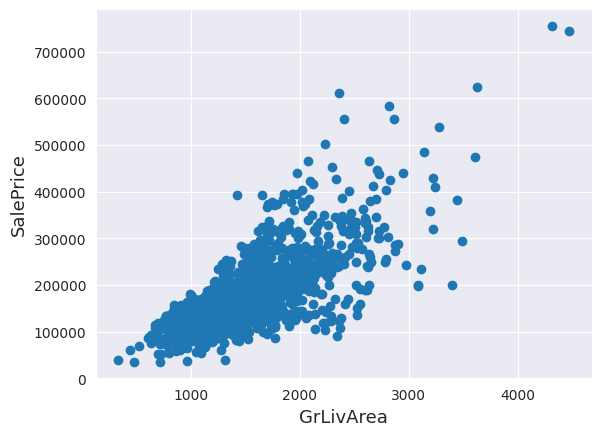

In [8]:
# check the graph again
fig, ax = plt.subplots()

ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice',fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

## **Target variable check : Q-Q plot**

180932.91906721535 79467.78892987774


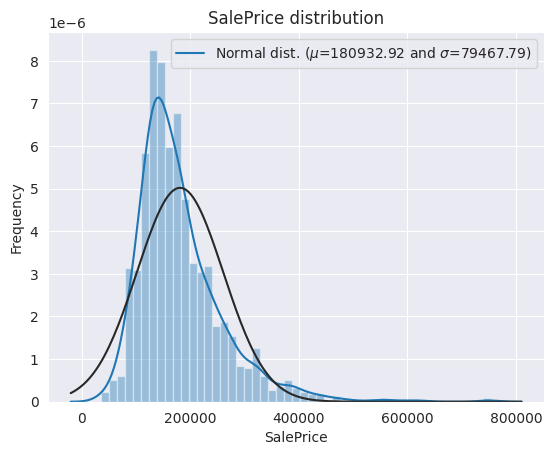

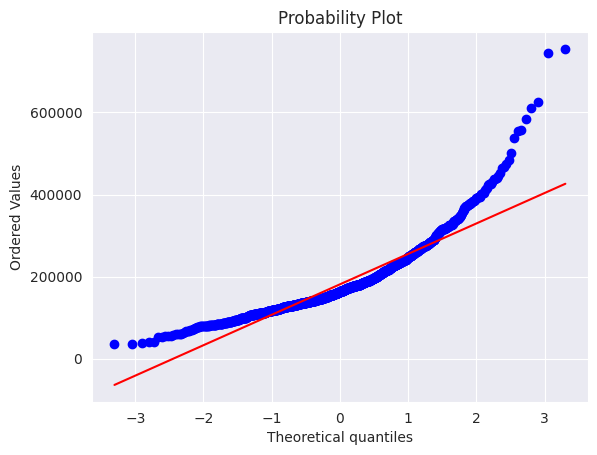

In [9]:
sns.distplot(train_df['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)

# 분포 시각화
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

Right-skewed distribution

선형모델은 분포가 정규분포 형태일 때 더 예측 성능이 좋으므로 log-transform 진행

12.024015155682552 0.3995757283645756


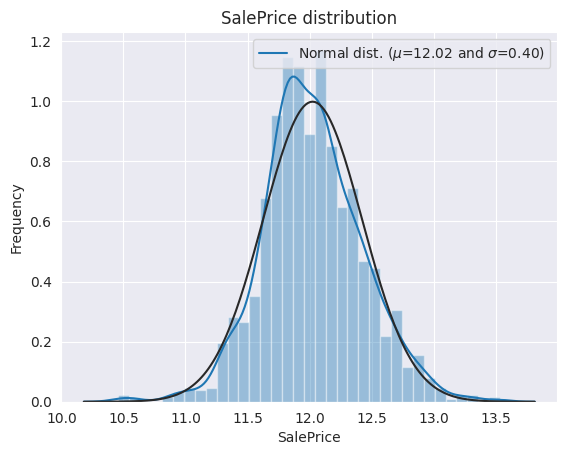

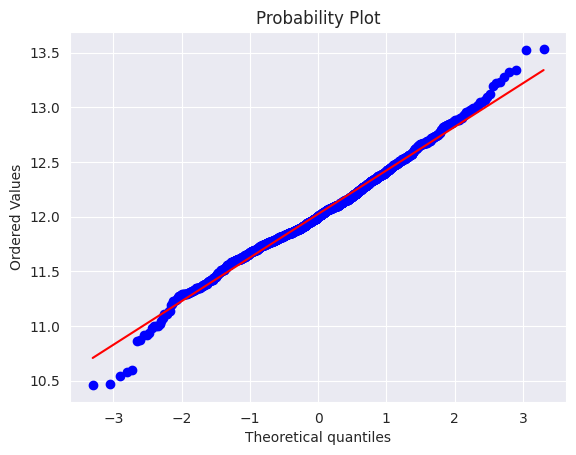

In [10]:
# target variable log transform
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# 위와 같은 코드로 시각화
sns.distplot(train_df['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)

# 분포 시각화
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

## **Feature Engineering**

In [11]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

y_train = train_df.SalePrice.values

# 데이터를 하나로 묶어서 사용
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print('all_data size is : {}'.format(all_data.shape))

all_data size is : (2917, 79)


**missing data check**

In [12]:
# missing data의 ratio 정보를 담은 all_data_na 생성
all_data_na = all_data.isnull().sum()/len(all_data)*100

# missing data가 있는 칼럼의 정보만 남김
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

# series > DataFrame
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
MasVnrType,60.542
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

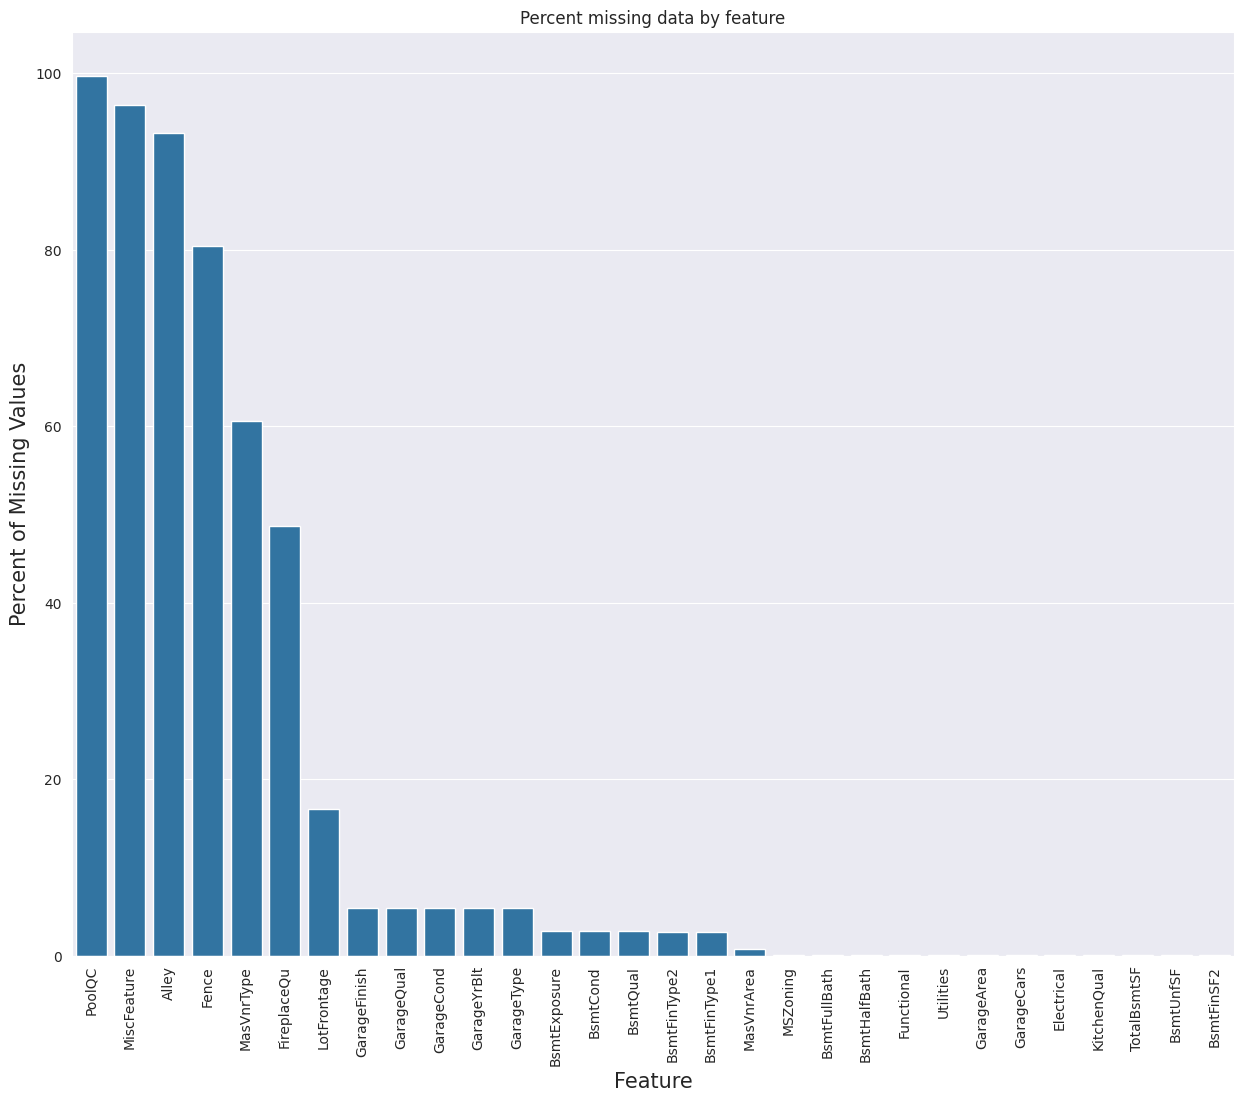

In [13]:
# visualization
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation=90)
sns.barplot(x=all_data_na.index, y = all_data_na)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Percent of Missing Values', fontsize=15)
plt.title('Percent missing data by feature')

**Data Correlation**

<Axes: >

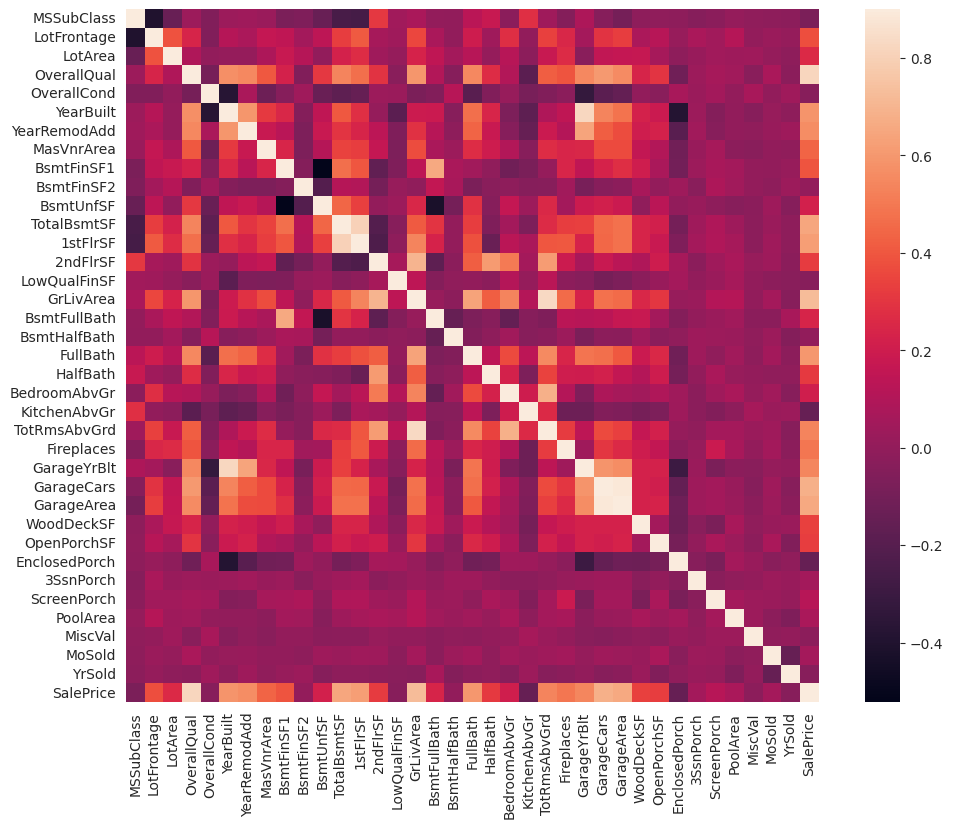

In [14]:
corrmat = train_df.corr(numeric_only=True)
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

**Inputing missing values**

* PoolQC : NA값은 "No Pool"을 의미 > 99%의 값을 'None'으로 채워줌
* MiscFeature : NA는 "no misc feature"
* Alley, Fence, FireplaceQu도 비슷하게 ~없다 이므로 함께 'None'으로 처리

In [15]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')
all_data['Alley'] = all_data['Alley'].fillna('None')
all_data['Fence'] = all_data['Fence'].fillna('None')
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

* LotFrontage : 거리와 집의 거리 요소로, 이 값들은 이웃들의 거리와 유사한 값. 손실된 값들은 이웃들의 중앙값으로 채움

In [16]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

* GarageType, GarageFinish, GarageQual and GarageCond : None으로 처리

In [17]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

다시 빈데이터들을 'None' 또는 0으로 처리

In [18]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [19]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [20]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [21]:
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)

* MSZoning (The general zoning classification) : 빈 부분은 최빈값인 RL로 채워주기
    * mode : 가장 많이 나타나는 값을 자동으로 선택하는 메서드

In [22]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

* Utilities : 모든 값이 "AllPub"으로 되어있고, 한 개가 "NoSeWa", 2개의 NA값이 있음 > 이는 예측하는 데에 있어 전혀 유용하지 않을 것이므로 drop

In [23]:
all_data = all_data.drop(['Utilities'], axis=1)

* Functional : 디스크립션에 의하면 NA는 typical을 의미

In [24]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

* Electrical, KitchenQual, Exterior1st and Exterior2nd, SaleType : 최빈값으로 채움

In [25]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [26]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

In [27]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

In [28]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [29]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna('None')

아직까지 채우지 못한 데이터가 있는지 체크

In [30]:
#Check remaining missing values if any
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### **More Feature Engineering**

**수치형 > 범주형**

In [31]:
# MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].apply(str)

# Year and Month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

**범주형 > label endcoding**

In [32]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


**Adding one more important feature**

주택 가격에서는 집의 가용 평수가 중요 > basement + 1층 + 2층 공간 값을 갖는 새 변수 생성

In [33]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

**Skewed feature**

In [34]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

# 수치형 데이터 skewness 체크
skewed_feats = all_data[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending = False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


skewed data > 정규 분포 형태 변환
* Box-cox Transformation of (highly) skewed features : 정규분포가 아닌 데이터를 정규 분포 형태로 변환하는 방법

In [35]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15

for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)



There are 59 skewed numerical features to Box Cox transform


**범주형 데이터 > 더미 변수**

In [36]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

(2917, 220)


# **Modeling**

In [37]:
# module import
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

Define a cross validation strategy

In [38]:
# Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(train_df.values)
    rmse = np.sqrt(-cross_val_score(model, train_df.values, y_train, scoring = 'neg_mean_squared_error', cv = kf))
    return rmse

## Base Models
* **Lasso Regression** : 이상치에 매우 민감함. 이상치를 규제하기 위해 pipeline에 RobustScaler() 메서드를 이용.
* **Elasticnet Regression** : 이상치를 규제하기 위해 pipeline에 RobustScaler() 메서드를 이용

RobustScaler는 데이터를 정규화(normalization)할 때 평균(mean)과 표준편차(standard deviation) 대신 중앙값(median)과 IQR(Interquartile Range)를 사용

In [39]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state = 1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005, l1_ratio = 0.9, random_state = 3))

* Kernel Ridge Regression

In [40]:
KRR = KernelRidge(alpha = 0.6, kernel = 'polynomial', degree = 2, coef0 = 2.5)

* Gradient Boosting Regression

huber 손실 함수로 이상치 관리. 이 손실함수는 다른 손실함수에 비해 이상치에 대해 민감하지 않음

In [41]:
GBoost = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05, max_depth = 4,
                                   max_features = 'sqrt', min_samples_leaf = 15, min_samples_split = 10,
                                   loss = 'huber', random_state = 5)

* XgBoost

하이퍼 파라미터 설정은 bayesian optimization을 사용

In [42]:
model_xgb = xgb.XGBRegressor(colsample_bytree = 0.4603, gamma = 0.0468,
                             learning_rate = 0.05, max_depth = 3,
                             min_child_weight = 1.7817, n_estimators = 2200,
                             reg_alpha = 0.4640, reg_lambda = 0.8571,
                             subsample = 0.5213,
                             random_state = 7, nthread = -1)

* LightGBM

In [43]:
model_lgb = lgb.LGBMRegressor(objective = 'regression',num_leaves = 5,
                              learning_rate = 0.05, n_estimators = 720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed = 9, bagging_seed = 9,
                              min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11, verbose = -1)

Base Model Scores

In [44]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [45]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [46]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [47]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0083)



In [48]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1167 (0.0068)



In [49]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1167 (0.0059)



## **Stacking Models**

Simplest Stacking Approach : Averaging Base Models

In [50]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X,y)

        return model

    # Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis = 1)

In [51]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.1087 (0.0077)



Less Simple Stacking : Adding a Meta-model

meta model을 추가하고, base model들의 평균과 이 out-of-folds 예측을 이용하여 meta-model을 훈련

In [52]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds = 5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # base_models_는 2차원 배열입니다.
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits = self.n_folds, shuffle = True, random_state = 156)

        # Train cloned base models then create out-of-fold predictions that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # 각 모델들의 평균값을 사용합니다.
    def predict(self, X):
        meta_features = np.column_stack([np.column_stack([model.predict(X) for model in base_models])
                                         .mean(axis = 1) for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)

Stacking Average models Score

In [54]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), meta_model = (lasso))

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


## **Emsembling StackedRegressor, XGBoost and LightGBM**

In [55]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

Final Training and prediction.

처음에 log1p를 통해 정규화를 해줬음 > 예측 결과도 log1p로 변환된 값이므로 expm1 함수를 통해 원래 스케일로 복원해야 함.

Stacked Regressor

In [56]:
stacked_averaged_models.fit(train_df.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train_df.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_df.values))
print(rmsle(y_train, stacked_train_pred))

0.07839506096665937


XgBoost

In [57]:
model_xgb.fit(train_df, y_train)
xgb_train_pred = model_xgb.predict(train_df)
xgb_pred = np.expm1(model_xgb.predict(test_df))
print(rmsle(y_train, xgb_train_pred))

0.0866951518038854


LightGBM

In [58]:
model_lgb.fit(train_df, y_train)
lgb_train_pred = model_lgb.predict(train_df)
lgb_pred = np.expm1(model_lgb.predict(test_df.values))
print(rmsle(y_train, lgb_train_pred))

0.07169383068991829


In [59]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

## 이 가중치는 Based on their cross-validation scores(and a bit of trial and errors)

RMSLE score on train data:
0.07653967781115523


Ensemble Prediction

In [60]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

Submission

In [61]:
sub = pd.DataFrame()
sub['SalePrice'] = ensemble
sub['Id'] = test_ID
sub.to_csv('submission.csv',index = False)